# Traffic Flow Forecasting

Armin Catovic<sup>ex-Ericsson</sup> <armin.catovic@schibsted.com>, <armin.catovic@hotmail.se>

## Introduction

In this notebook we perform univariate traffic flow forecasting. The aim is to predict the number of vehicles in the next 15-min interval, for a specific road segment in Birkastan, Stockholm. We re-use the same dataset previously used in *EP231U*. However, instead of performing multivariate regression, we treat this as a time-series univariate forecasting problem. In the process, we evaluate a number of different algorithms and report various metrics.


## Background

Traffic forecasting is an important problem encountered by transport authorities and city municipalities. There are two kinds of traffic forecasting problems - short-term and long-term. Long-term forecasts are relevant for city and infrastructure planning, i.e. expanding roads, changing speed limits, and providing more public transport. In this notebook we deal with short-term forecasts. Short-term forecasting (e.g. next 15-min predictions) are useful for quickly identifying congestion and traffic accidents, and can be useful for route planning and optimization. Google Maps for example, uses forecasting to indicate estimated time of arrival (ETA).


## Method

We re-use one of the [existing notebooks on GitHub](https://github.com/jiwidi/time-series-forecasting-with-python), as referenced in the EP232U assignment description. Our dataset consists of 15-min aggregate vehicle counts, recorded from 1 April until 30 September 2020. The vehicle counts are captured by an over-roadway laser detector. There is one detector per lane, however, the lanes are grouped by in-bound/out-bound direction of traffic flow. Each unique in-bound/out-bound group is in turn represented by an integer ID. In City of Stockholm, an ID ending with an odd number represents in-bound (towards the city centre), while an ID ending with an even number represents out-bound flow. In our dataset we have two traffic flow IDs, however to keep things simple (and quick) for the purpose of this assignment, we add the two together, thereby forecasting the **total** number of vehicles only.

We approach the problem as follows:

* We first load and re-shape the data, and impute the missing values
* We then build couple of simple models for baseline comparison
* We evaluate a number of forecasting models in increasing levels of complexity, namely:
    * Simple Exponential Smoothing (SES)
    * Holt Winter's Exponential Smoothing (HWES)
    * Autoregression (AR)
    * Moving Average (MA)
    * Prophet
* For each forecasting model with capture the following metrics: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), and the coefficient of determination, $R^2$

## Results

In the following section we load the data and evaluate a number of different forecasting algorithms.

In [74]:
# imports

from fbprophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from tqdm import tqdm, tqdm_notebook

from metrics import evaluate


# global settings

seed = 42
np.random.seed(seed)
plt.style.use('bmh')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
plt.rcParams['figure.figsize'] = (18, 8)

In [3]:
# load data

data_path = 'https://raw.githubusercontent.com/acatovic/kth-traffic-counter/main/data/targets.csv'
d = pd.read_csv(data_path)
print(d)

                 StartTime  StationId  NumberOfVehicles
0      2020-04-01 00:00:00        101                28
1      2020-04-01 00:00:00        102                44
2      2020-04-01 00:15:00        102                40
3      2020-04-01 00:15:00        101                22
4      2020-04-01 00:30:00        101                15
...                    ...        ...               ...
34799  2020-09-30 23:15:00        101                52
34800  2020-09-30 23:30:00        102                89
34801  2020-09-30 23:30:00        101                43
34802  2020-09-30 23:45:00        102                68
34803  2020-09-30 23:45:00        101                64

[34804 rows x 3 columns]


In [4]:
print(d['StationId'].unique())

[101 102]


In [5]:
print('StationId 101 # of samples: ', len(d[d['StationId'] == 101]))
print('StationId 102 # of samples: ', len(d[d['StationId'] == 102]))

StationId 101 # of samples:  17386
StationId 102 # of samples:  17418


In [6]:
# create a new dataframe where each station id is its own column

stations = d['StationId'].unique()
d['StartTime'] = pd.to_datetime(d['StartTime'])
d = d.set_index('StartTime')
d2 = pd.DataFrame(columns=stations)
for station in stations:
        d2[station] = d[d['StationId'] == station]['NumberOfVehicles']
print(d2)

                     101    102
StartTime                      
2020-04-01 00:00:00   28   44.0
2020-04-01 00:15:00   22   40.0
2020-04-01 00:30:00   15   34.0
2020-04-01 00:45:00   17   24.0
2020-04-01 01:00:00   19   27.0
...                  ...    ...
2020-09-30 22:45:00   79  136.0
2020-09-30 23:00:00   70   89.0
2020-09-30 23:15:00   52   96.0
2020-09-30 23:30:00   43   89.0
2020-09-30 23:45:00   64   68.0

[17386 rows x 2 columns]


In [7]:
print(d2.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17386 entries, 2020-04-01 00:00:00 to 2020-09-30 23:45:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   101     17386 non-null  int64  
 1   102     17305 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 407.5 KB
None


In [8]:
print(d2[d2[102].isna()])

                     101  102
StartTime                    
2020-04-01 22:30:00   63  NaN
2020-04-01 22:45:00   56  NaN
2020-04-01 23:00:00   56  NaN
2020-04-01 23:15:00   28  NaN
2020-04-01 23:45:00    3  NaN
...                  ...  ...
2020-08-28 03:00:00   17  NaN
2020-08-28 03:15:00   17  NaN
2020-08-28 03:45:00   18  NaN
2020-08-28 04:00:00   21  NaN
2020-08-28 04:15:00   26  NaN

[81 rows x 2 columns]


In [9]:
# Since there are only 81/17386 = 0,5% of values missing,
# we will use KNN imputation; this makes it easier for us,
# since we don't have to then worry about complicated splitting
# of time series data during training

imputer = KNNImputer(n_neighbors=2, weights="uniform")
d2[[101, 102]] = imputer.fit_transform(d2[[101, 102]])
print(d2.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17386 entries, 2020-04-01 00:00:00 to 2020-09-30 23:45:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   101     17386 non-null  float64
 1   102     17386 non-null  float64
dtypes: float64(2)
memory usage: 407.5 KB
None


In [10]:
# add the two sensors together, since we're forecasting TOTAl number of vehicles

d2['Total'] = d2[101] + d2[102]
print(d2)

                      101    102  Total
StartTime                              
2020-04-01 00:00:00  28.0   44.0   72.0
2020-04-01 00:15:00  22.0   40.0   62.0
2020-04-01 00:30:00  15.0   34.0   49.0
2020-04-01 00:45:00  17.0   24.0   41.0
2020-04-01 01:00:00  19.0   27.0   46.0
...                   ...    ...    ...
2020-09-30 22:45:00  79.0  136.0  215.0
2020-09-30 23:00:00  70.0   89.0  159.0
2020-09-30 23:15:00  52.0   96.0  148.0
2020-09-30 23:30:00  43.0   89.0  132.0
2020-09-30 23:45:00  64.0   68.0  132.0

[17386 rows x 3 columns]


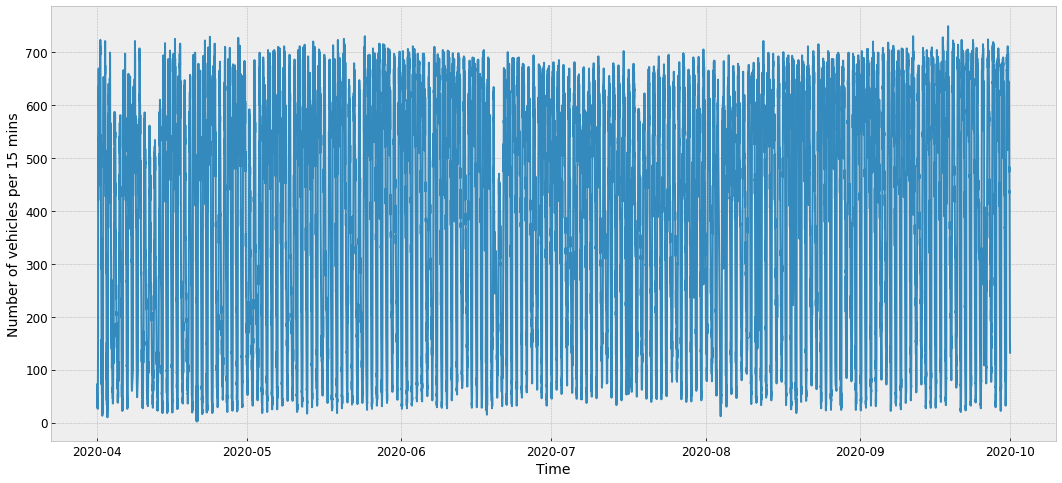

In [12]:
# We can plot the number of vehicles over time
# Notice the dip in mid-June - due to Swedish midsommar
# Also a dip in 1st half of April, due to COVID-19 pandemic
# and people's initial fear and staying home; however no
# lockdowns were implemented and traffic returned more-or-less
# back to normal

plt.plot(d2['Total'])
plt.xlabel('Time')
plt.ylabel('Number of vehicles per 15 mins')
plt.show()

In [59]:
# prepare data for forecasting
# we will record all the forecasted values for different algorithms,
# as well as all the evaluation metrics, i.e. MAE, RMSE, MAPE and R2;
# we split the data as follows - 1 April until 31 August is training set,
# 1 September until 30 September is test set

results = {}

d_train = d2[:'2020-08-31'].reset_index()
x_train = d_train['StartTime']
y_train = np.array(d_train['Total'])

d_test = d2['2020-09-01':].reset_index()
x_test = d_test['StartTime']
y_test = np.array(d_test['Total'])
print(f'{len(x_train)} days of training data')
print(f'{len(x_test)} days of test data')

14524 days of training data
2862 days of test data


Naive Mean: {'mae': 214.14693658097798, 'rmse': 236.69545205420366, 'mape': 1.6439879349215674, 'r2': 0.0}


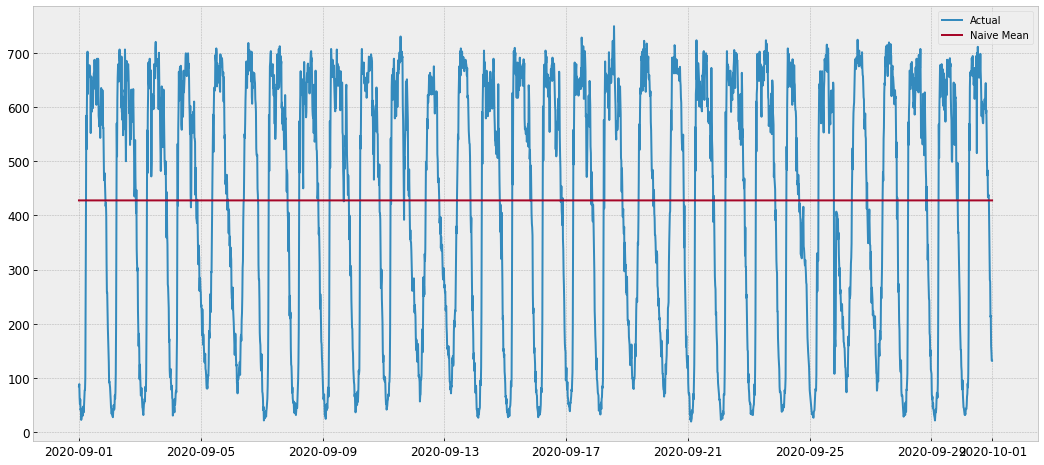

In [76]:
# let's first forecast using very naive methods,
# namely, data mean, and previous value

y_hat = np.full(len(x_test), y_test.mean())
results['NaiveMean'] = evaluate(y_test, y_hat)
print(f'Naive Mean: {results["NaiveMean"]}')

plt.plot(x_test, y_test, label='Actual')
plt.plot(x_test, y_hat, label='Naive Mean')
plt.legend()
plt.show()

Previous Value: {'mae': 30.204751921733052, 'rmse': 44.87790720228321, 'mape': 0.10230320174673313, 'r2': 0.9640511198825485}


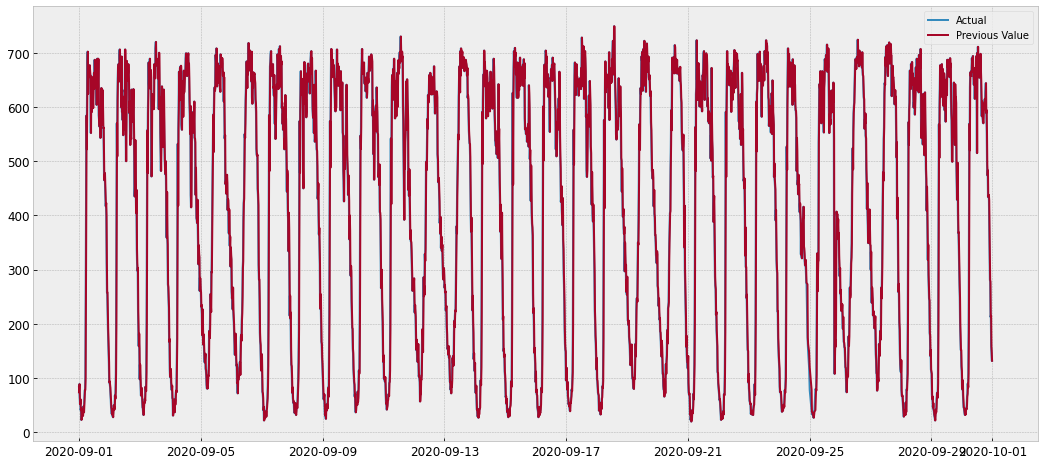

In [77]:
# using previous value

y_hat = np.concatenate((y_train[-1], y_test[:-1]), axis=None)
results['PreviousValue'] = evaluate(y_test, y_hat)
print(f'Previous Value: {results["PreviousValue"]}')

plt.plot(x_test, y_test, label='Actual')
plt.plot(x_test, y_hat, label='Previous Value')
plt.legend()
plt.show()

  0%|          | 0/2862 [00:00<?, ?it/s]/home/acatovic/py38/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
100%|██████████| 2862/2862 [05:10<00:00,  9.23it/s]


SES: {'mae': 30.209745644151663, 'rmse': 44.900568557762405, 'mape': 0.10233905240442584, 'r2': 0.9640148055317513}


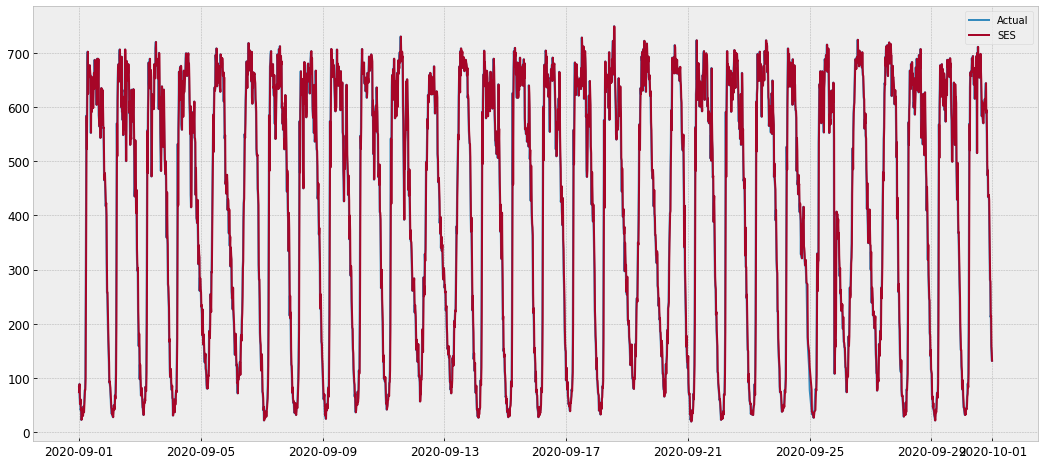

In [78]:
# Simple Exponential Smoothing (SES)

y_hat = []
for t in tqdm(range(len(y_test))):
    temp_train = np.concatenate((y_train, y_test[:t]), axis=None)
    model = SimpleExpSmoothing(temp_train).fit()
    y_hat.extend(model.predict(start=len(temp_train), end=len(temp_train)))

results['SES'] = evaluate(y_test, y_hat)
print(f'SES: {results["SES"]}')

plt.plot(x_test, y_test, label='Actual')
plt.plot(x_test, y_hat, label='SES')
plt.legend()
plt.show()

  0%|          | 0/2862 [00:00<?, ?it/s]/home/acatovic/py38/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
100%|██████████| 2862/2862 [04:20<00:00, 10.99it/s]


HWES: {'mae': 30.209745644151663, 'rmse': 44.900568557762405, 'mape': 0.10233905240442584, 'r2': 0.9640148055317513}


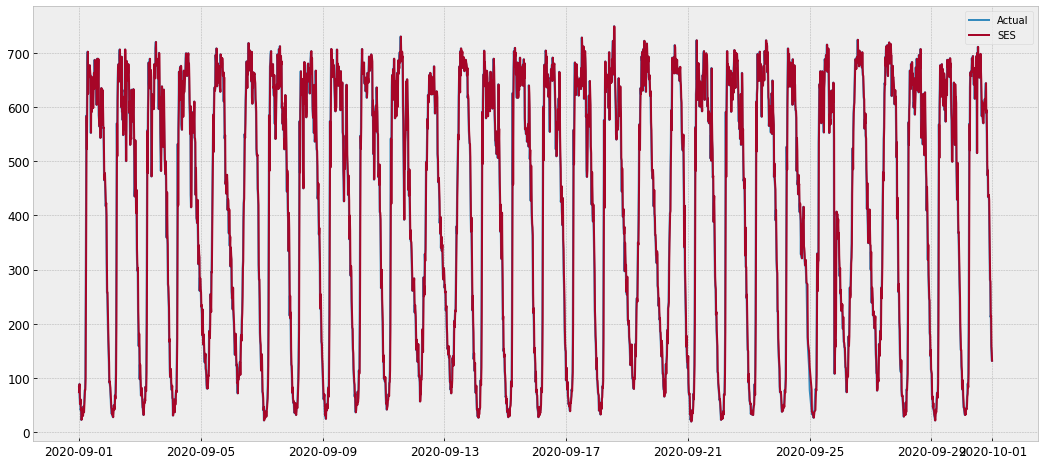

In [79]:
# Holt Winter's Exponential Smoothing (HWES)

y_hat = []
for t in tqdm(range(len(y_test))):
    temp_train = np.concatenate((y_train, y_test[:t]), axis=None)
    model = ExponentialSmoothing(temp_train).fit()
    y_hat.extend(model.predict(start=len(temp_train), end=len(temp_train)))

results['HWES'] = evaluate(y_test, y_hat)
print(f'HWES: {results["HWES"]}')

plt.plot(x_test, y_test, label='Actual')
plt.plot(x_test, y_hat, label='HWES')
plt.legend()
plt.show()

  0%|          | 0/2862 [00:00<?, ?it/s]/home/acatovic/py38/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings

AR: {'mae': 27.66022270397593, 'rmse': 41.509026121796246, 'mape': 0.09978132720581105, 'r2': 0.9692457414147577}


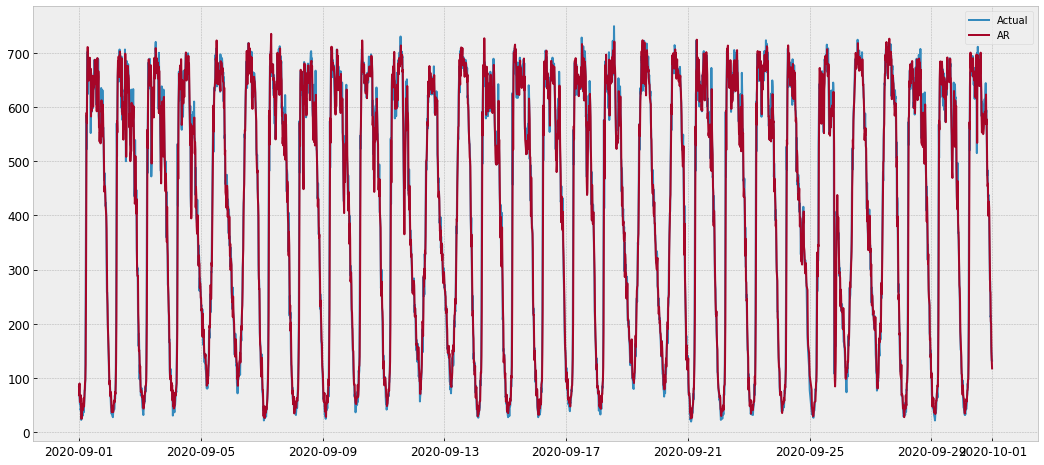

In [80]:
# Autoregression (AR)

y_hat = []
for t in tqdm(range(len(y_test))):
    temp_train = np.concatenate((y_train, y_test[:t]), axis=None)
    model = AR(temp_train).fit()
    y_hat.extend(model.predict(start=len(temp_train), end=len(temp_train), dynamic=False))

results['AR'] = evaluate(y_test, y_hat)
print(f'AR: {results["AR"]}')

plt.plot(x_test, y_test, label='Actual')
plt.plot(x_test, y_hat, label='AR')
plt.legend()
plt.show()

  0%|          | 0/2862 [00:00<?, ?it/s]/home/acatovic/py38/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
100%|██████████| 2862/2862 [2:13:48<00:00,  2.81s/it]  


MA: {'mae': 120.77730446671221, 'rmse': 135.41646761865024, 'mape': 0.8206001725268184, 'r2': 0.6726870900841948}


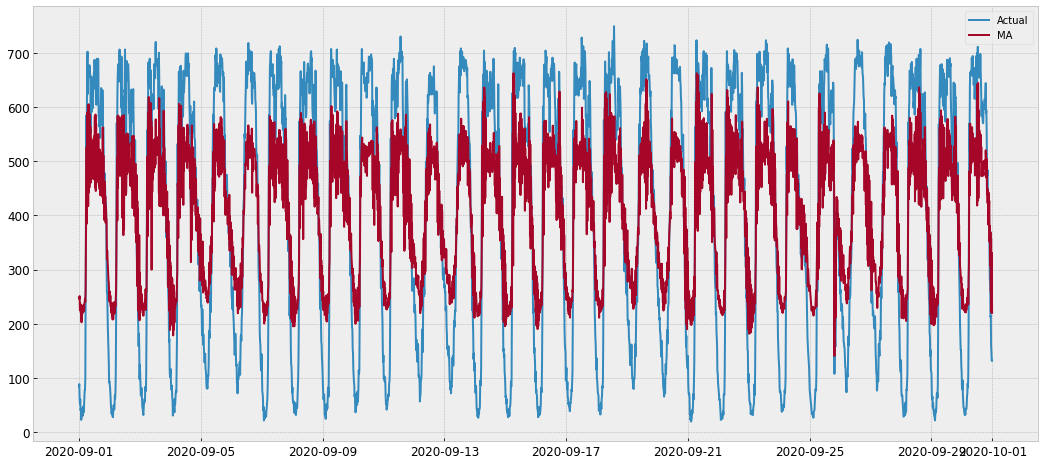

In [81]:
# Moving Average (MA)

y_hat = []
for t in tqdm(range(len(y_test))):
    temp_train = np.concatenate((y_train, y_test[:t]), axis=None)
    model = ARMA(temp_train, order=(0, 1)).fit()
    y_hat.extend(model.predict(start=len(temp_train), end=len(temp_train), dynamic=False))

results['MA'] = evaluate(y_test, y_hat)
print(f'MA: {results["MA"]}')

plt.plot(x_test, y_test, label='Actual')
plt.plot(x_test, y_hat, label='MA')
plt.legend()
plt.show()

The results from AR/MA/ARMA/ARIMA are starting to look ridiculous, we we will stop here and try Prophet instead.

In [90]:
# Prophet (FB)
# First we prepare data for prophet training

prophet_train = d_train[['StartTime', 'Total']].set_index('StartTime')
prophet_train.rename(columns={'Total': 'y'}, inplace=True)
prophet_train['ds'] = prophet_train.index
prophet_train.index = pd.RangeIndex(len(prophet_train.index))

prophet_test = d_test[['StartTime', 'Total']].set_index('StartTime')
prophet_test.rename(columns={'Total': 'y'}, inplace=True)
prophet_test['ds'] = prophet_test.index
prophet_test.index = pd.RangeIndex(len(prophet_test.index))

print(f'Train dataframe:\n{prophet_train}\n')
print(f'Test dataframe:\n{prophet_test}\n')

Train dataframe:
           y                  ds
0       72.0 2020-04-01 00:00:00
1       62.0 2020-04-01 00:15:00
2       49.0 2020-04-01 00:30:00
3       41.0 2020-04-01 00:45:00
4       46.0 2020-04-01 01:00:00
...      ...                 ...
14519  158.0 2020-08-31 22:45:00
14520  129.0 2020-08-31 23:00:00
14521   95.0 2020-08-31 23:15:00
14522  117.0 2020-08-31 23:30:00
14523   74.0 2020-08-31 23:45:00

[14524 rows x 2 columns]

Test dataframe:
          y                  ds
0      85.0 2020-09-01 00:00:00
1      89.0 2020-09-01 00:15:00
2      64.0 2020-09-01 00:30:00
3      52.0 2020-09-01 00:45:00
4      61.0 2020-09-01 01:00:00
...     ...                 ...
2857  215.0 2020-09-30 22:45:00
2858  159.0 2020-09-30 23:00:00
2859  148.0 2020-09-30 23:15:00
2860  132.0 2020-09-30 23:30:00
2861  132.0 2020-09-30 23:45:00

[2862 rows x 2 columns]



In [93]:
prophet = Prophet(
    growth='linear',
    seasonality_mode='multiplicative',
    holidays_prior_scale=20,
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False
).add_seasonality(
    name='monthly', 
    period=30.5,
    fourier_order=55
).add_seasonality(
    name='daily',
    period=1,
    fourier_order=15
).add_seasonality(
    name='weekly',
    period=7,
    fourier_order=25
).add_seasonality(
    name='quarterly',
    period=365.25/4.,
    fourier_order=55
).add_country_holidays(country_name='Sweden')

Prophet: {'mae': 67.8336935931598, 'rmse': 90.54918190293255, 'mape': 0.2703688429578793, 'r2': 0.8536511766239385}


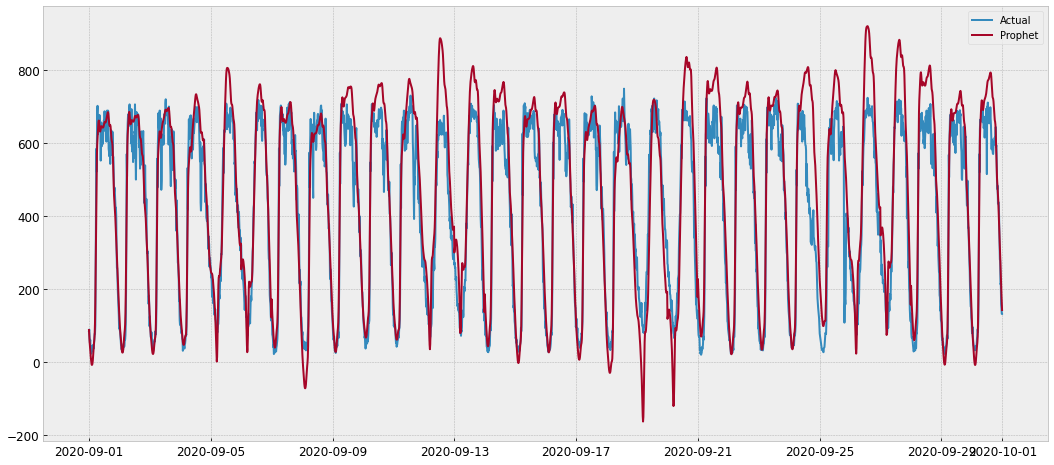

In [94]:
prophet.fit(prophet_train)
y_hat = prophet.predict(prophet_test)
results['Prophet'] = evaluate(y_test, y_hat.yhat.values)
print(f'Prophet: {results["Prophet"]}')

plt.plot(x_test, y_test, label='Actual')
plt.plot(x_test, y_hat.yhat.values, label='Prophet')
plt.legend()
plt.show()

In [119]:
print('{:>14} |{:>8} |{:>8} |{:>8} |{:>8} |'.format('model', 'mae', 'rmse', 'mape', 'r2'))
print('-'*56)
for model in results:
    print('{:>14} |{:>8.2f} |{:>8.2f} |{:>8.2f} |{:>8.2f} |'.format(
        model, 
        results[model]['mae'], 
        results[model]['rmse'], 
        results[model]['mape'], 
        results[model]['r2']))

         model |     mae |    rmse |    mape |      r2 |
--------------------------------------------------------
     NaiveMean |  214.15 |  236.70 |    1.64 |    0.00 |
 PreviousValue |   30.20 |   44.88 |    0.10 |    0.96 |
           SES |   30.21 |   44.90 |    0.10 |    0.96 |
          HWES |   30.21 |   44.90 |    0.10 |    0.96 |
            AR |   27.66 |   41.51 |    0.10 |    0.97 |
            MA |  120.78 |  135.42 |    0.82 |    0.67 |
       Prophet |   67.83 |   90.55 |    0.27 |    0.85 |


## Conclusion

In this notebook we evaluated a number of different univariate forecasting algorithms. We used different evaluation metrics including MAE, RMSE, MAPE, and R<sup>2</sup>. Due to a very strong seasonality present in the dataset, simple forecasting methods would be expected to perform very well. The best forecasting accuracy was achieved by an autoregression (AR) model. However this was only marginally better than simply using the previous 15-min interval value. The latter is almost instantaneous, while AR took over 6 minutes to execute. It is interesting to see that even state-of-the-art forecasting method like Prophet performed poorly. Such methods might be better suited for long-term forecasts instead.